<a href="https://colab.research.google.com/github/marama09/Eyes_Disease/blob/main/Glaucoma_Eyes_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I performed a superficial exploratory data analysis, investigated the relationship between diagnostic keyphrases and diagnosed conditions and, based on the latter, implemented some code to sort images of retinal fundi, according to conditions whose symptoms they display.




In [ ]:
# Import everything we need
import os
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt, image as mpimg
from tqdm import tqdm
from time import time
from collections import Counter
import random
import glob
import seaborn as sns
%matplotlib inline 
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, utils, callbacks
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set up all the paths

train_dir = '/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images/'
img_dir = "/content/drive/MyDrive/Ocular Disease/preprocessed_images"
IMG_DIR = '/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images/'
file_names = sorted(os.listdir(IMG_DIR))
DATA_FOLDER='/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images'

First, let's load our data to a DataFrame and take a look at it



In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Ocular Disease/full_df.csv")
df.head()

ID  Patient Age Patient Sex  ... labels                    target     filename
0   0           69      Female  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg
1   1           57        Male  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg
2   2           42        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg
3   4           53        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg
4   5           50      Female  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

[5 rows x 19 columns]

In [ ]:
#Rename columns
df.columns = ["ID", 'Age', "Patient Sex", "Left_Fundus", "Right_Fundus", "Left_Diagnostic", "Right_Diagnostic","Normal","Diabetes", "Glaucoma", "Cataract", "Amd", "Hypertension", "Myopia", "Other","filepath","labels", "target", "filename"]

In [ ]:
df.head()

ID  Age Patient Sex  ... labels                    target     filename
0   0   69      Female  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg
1   1   57        Male  ...  ['N']  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg
2   2   42        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  2_right.jpg
3   4   53        Male  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  4_right.jpg
4   5   50      Female  ...  ['D']  [0, 1, 0, 0, 0, 0, 0, 0]  5_right.jpg

[5 rows x 19 columns]

In [ ]:
print(f"data shape: {df.shape}")
print(f"Left-Fundus: {df.Left_Fundus.nunique()}")
print(f"right fundus: {df.Right_Fundus.nunique()}")

data shape: (6392, 19)
Left-Fundus: 3358
right fundus: 3358


**We have 6392 records, and unique images associated with each record for left and respectively right eye.**

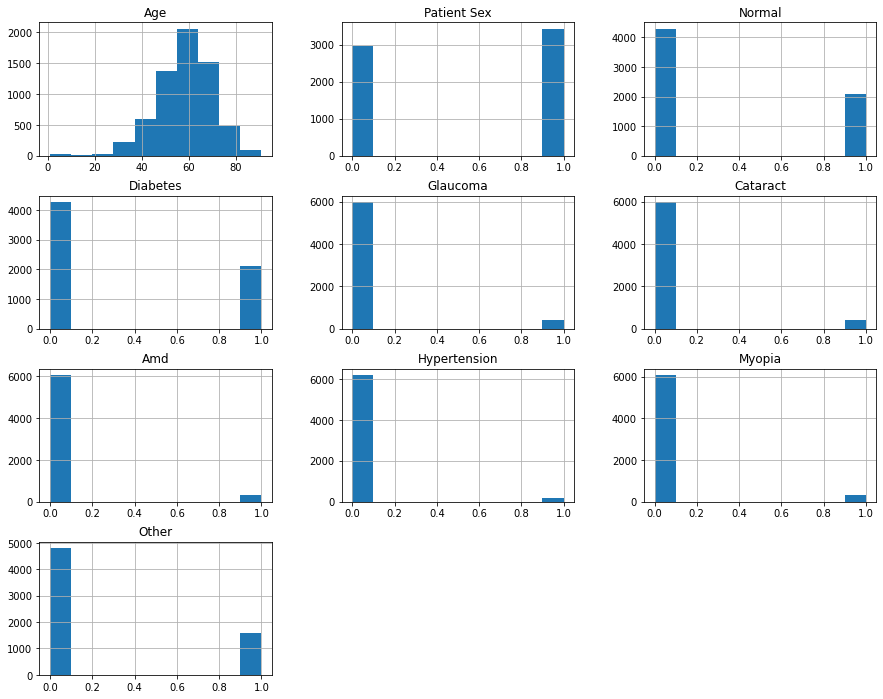

In [ ]:
data_num = df.copy()[['Age', 'Patient Sex', "Normal","Diabetes", "Glaucoma", "Cataract", "Amd", "Hypertension", "Myopia", "Other"]]
data_num['Patient Sex'] = data_num['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # we encode sex: Female => 0; Male => 1

data_num.hist(figsize=(15,12))

plt.show()

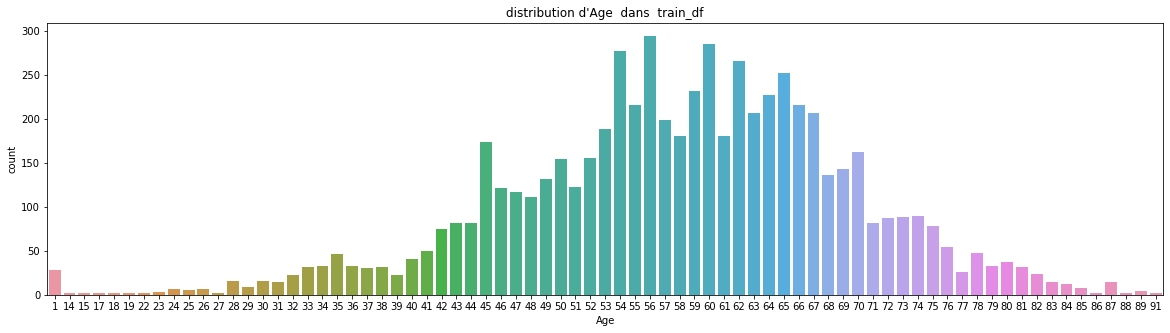

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(20,5))
sns.countplot(ax=ax1, x="Age", data=df)
ax1.set_title("distribution d'Age  dans  train_df")
plt.show()

We can see a few interesting things here:

1) The most prominent age group are people in about their 60s.

2) There is slightly more males than females.

3) Most patients are not healthy, but healthy patients are the most prevalent of all groups.

4) The most prevalent non-healthy group are patients with diabetes, with "other" coming right after them.

Since this "other" category likely lumps many non-related and quite heterogenous conditions, it's going to be more efficient to focus on diabetic patients.

For now, we will build a model which will discriminate healthy retinas from those displaying signs of diabetes. Later we will test its performance how it performs on the images of retinas with signs of other diseases and see whether we can gain some insight from it.

One more thing: let's take a peek at correlations

**Check image data**
We check now the image data for completeness.

In [ ]:
print(f"train images: {len(os.listdir('/content/drive/MyDrive/Ocular Disease/ODIR-5K/Training Images'))}")

train images: 7000


There are 7000 images in training set and 1000 images in testing set, with half of them for left eye and half of them for right eye.

Since there is only one flag for each patology, and we have same record for both eyes for each patient, we will need to infer from the left diagnosys, respectively from right diagnosis, to which eye reffers the flag.

For example, for patient with id 0 (Female, age 69), there is a flag 1 for cataract. Looking to the left_diagnosys and right_diagnosys, we observe that only for left_diagnosys we have cataract marked. Consequently, if we want to train a model to recognize cataract, we will only label left eye (image 0_left.png as being with cataract flag 1.

In [ ]:
%matplotlib inline
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("Number{}".format(title))
        plt.show()    

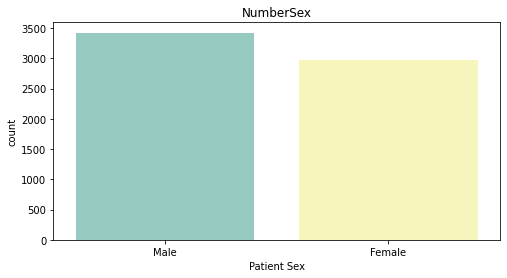

In [ ]:
plot_count("Patient Sex", "Sex", df, size=2);

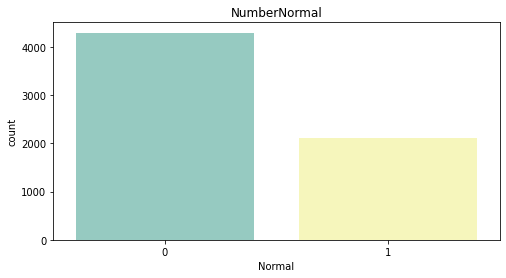

In [ ]:
plot_count("Normal", "Normal", df, size=2);

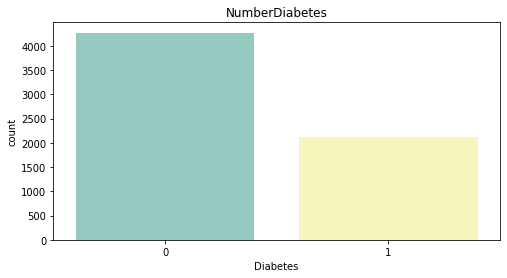

In [ ]:
plot_count("Diabetes", "Diabetes", df, size=2)

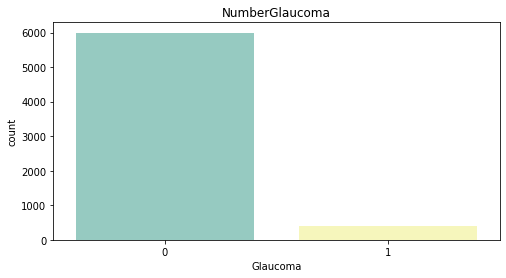

In [ ]:
plot_count("Glaucoma", "Glaucoma", df, size=2);

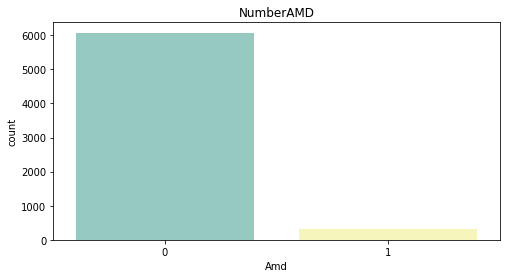

In [ ]:
plot_count("Amd", "AMD", df, size=2);

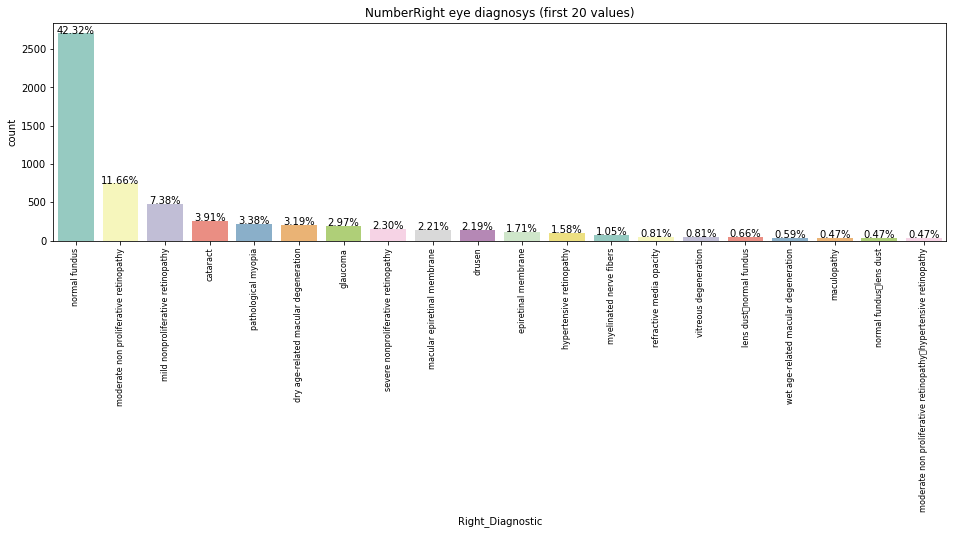

In [ ]:
plot_count("Right_Diagnostic", "Right eye diagnosys (first 20 values)", df, size=4)

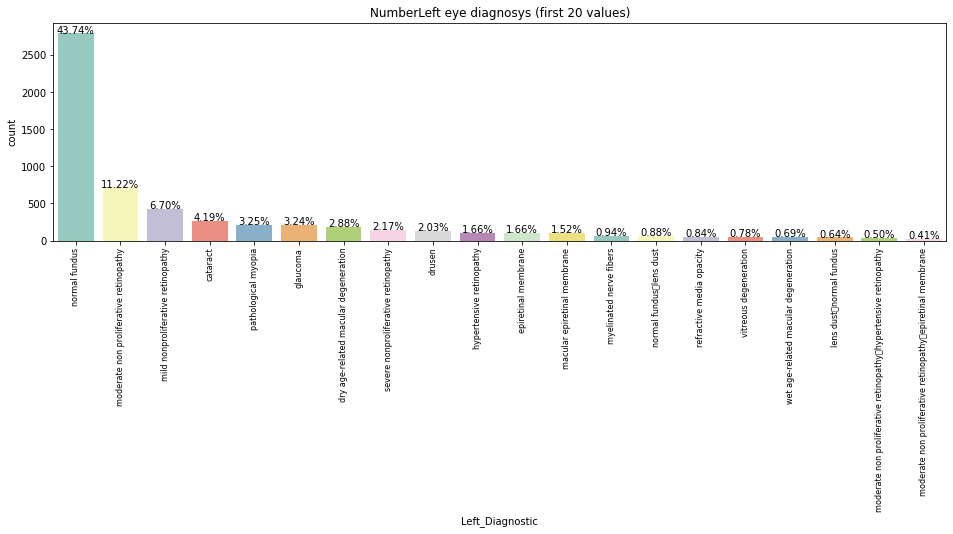

In [ ]:
plot_count("Left_Diagnostic", "Left eye diagnosys (first 20 values)", df, size=4)

Let's check now frequence of words used in diagnosys for left and right eye, as a wordcloud, to see what are the most frequent words used in such diagnosys.


In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1,
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
df.loc[(df.Glaucoma==1)]['Left_Diagnostic'].value_counts()

glaucoma                                                                    207
normal fundus                                                                28
suspected glaucoma                                                           22
dry age-related macular degeneration，glaucoma                                12
glaucoma，diabetic retinopathy                                                11
glaucoma，macular epiretinal membrane                                         10
moderate non proliferative retinopathy                                        8
suspected glaucoma，moderate non proliferative retinopathy                     8
glaucoma，myopia retinopathy                                                   8
glaucoma，lens dust                                                            6
refractive media opacity                                                      6
glaucoma，moderate non proliferative retinopathy                               5
diabetic retinopathy                    

In [ ]:
df.loc[(df.Glaucoma==1)]['Right_Diagnostic'].value_counts()

glaucoma                                                               190
normal fundus                                                           54
suspected glaucoma                                                      13
glaucoma，diabetic retinopathy                                           12
dry age-related macular degeneration，glaucoma                           11
glaucoma，myopia retinopathy                                              8
refractive media opacity                                                 7
glaucoma，hypertensive retinopathy                                        7
drusen                                                                   4
moderate non proliferative retinopathy，suspected glaucoma                4
maculopathy                                                              4
glaucoma，old central retinal vein occlusion                              4
suspected glaucoma，refractive media opacity                              4
moderate non proliferativ

In [ ]:
df2= df.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df2.head()

Age  ...                        Right_Diagnostic
0   69  ...                           normal fundus
1   57  ...                           normal fundus
2   42  ...  moderate non proliferative retinopathy
3   53  ...       mild nonproliferative retinopathy
4   50  ...  moderate non proliferative retinopathy

[5 rows x 6 columns]

In [ ]:
# Left diagnosis with 'cataract' keyword
df2[df2['Left_Diagnostic'].str.match('glaucoma')].head()

Age Patient Sex  ... Left_Diagnostic                      Right_Diagnostic
129   79        Male  ...        glaucoma  dry age-related macular degeneration
141   71        Male  ...        glaucoma                              glaucoma
510   54        Male  ...        glaucoma                              glaucoma
986   69      Female  ...        glaucoma                              glaucoma
987   62        Male  ...        glaucoma                              glaucoma

[5 rows x 6 columns]

In [ ]:
# Right diagnosis with 'cataract' keyword
df2[df2['Right_Diagnostic'].str.match('glaucoma')].head()

Age  ...              Right_Diagnostic
141   71  ...                      glaucoma
510   54  ...                      glaucoma
986   69  ...                      glaucoma
987   62  ...                      glaucoma
988   80  ...  glaucoma，optic nerve atrophy

[5 rows x 6 columns]

In [ ]:
df_left_gal = df2[df2['Left_Diagnostic'].str.match('glaucoma')]
print(len(df_left_gal))

262


In [ ]:
df_rt_gal = df[df['Right_Diagnostic'].str.match('glaucoma')]
print(len(df_rt_gal))

232


In [ ]:
df_gal_filenames = df_left_gal['Left_Fundus'].append(df_rt_gal['Right_Fundus'], ignore_index=True)
df_gal_filenames.head()

0     153_left.jpg
1     167_left.jpg
2     583_left.jpg
3    1209_left.jpg
4    1210_left.jpg
dtype: object

In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows
df_rt_norm = df[df['Right_Diagnostic'].str.match('normal')]
print(len(df_rt_norm))

2735


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df[df['Left_Diagnostic'].str.match('normal')]
print(len(df_left_norm))

2855


In [ ]:
#Combine normal filename data
df_norm_filenames = df_left_norm['Left_Fundus'].append(df_rt_norm['Right_Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [ ]:
df_norm_filenames_random = df_norm_filenames.sample(n = 494)
df_norm_filenames_random.head()

3455    2670_right.jpg
3068    1119_right.jpg
2767     4176_left.jpg
302      2371_left.jpg
4421    1028_right.jpg
dtype: object

In [ ]:
#Add category label to list
df_gal_filenames = pd.DataFrame(df_gal_filenames, columns = ["filename"])

# add a new column of '1' to the dataframe
df_gal_filenames["label"] = "glaucoma"

df_gal_filenames.head()

filename     label
0   153_left.jpg  glaucoma
1   167_left.jpg  glaucoma
2   583_left.jpg  glaucoma
3  1209_left.jpg  glaucoma
4  1210_left.jpg  glaucoma

In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

filename   label
3455  2670_right.jpg  normal
3068  1119_right.jpg  normal
2767   4176_left.jpg  normal
302    2371_left.jpg  normal
4421  1028_right.jpg  normal

In [ ]:
#Append dataframes into a single dataset
df_combined = df_gal_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

filename     label
0      153_left.jpg  glaucoma
1      167_left.jpg  glaucoma
2      583_left.jpg  glaucoma
3     1209_left.jpg  glaucoma
4     1210_left.jpg  glaucoma
..              ...       ...
983  3363_right.jpg    normal
984   3103_left.jpg    normal
985  3423_right.jpg    normal
986   4076_left.jpg    normal
987  4237_right.jpg    normal

[988 rows x 2 columns]

In [ ]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

filename     label
0     1491_left.jpg  glaucoma
1     1306_left.jpg  glaucoma
2    1365_right.jpg  glaucoma
3    2661_right.jpg    normal
4     2630_left.jpg    normal
..              ...       ...
983  1288_right.jpg  glaucoma
984  1433_right.jpg  glaucoma
985  3018_right.jpg    normal
986   1213_left.jpg  glaucoma
987  1251_right.jpg  glaucoma

[988 rows x 2 columns]

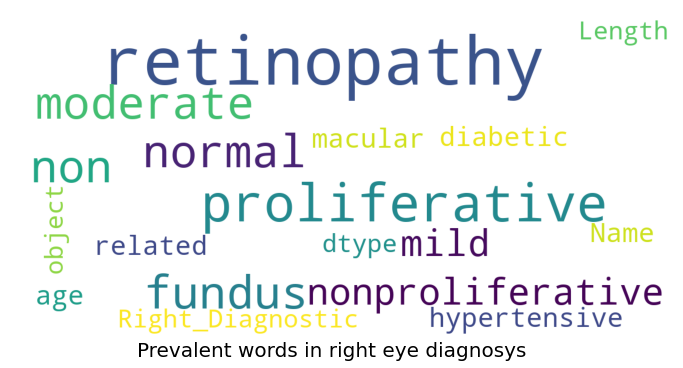

In [ ]:
show_wordcloud(df['Right_Diagnostic'], title = 'Prevalent words in right eye diagnosys')

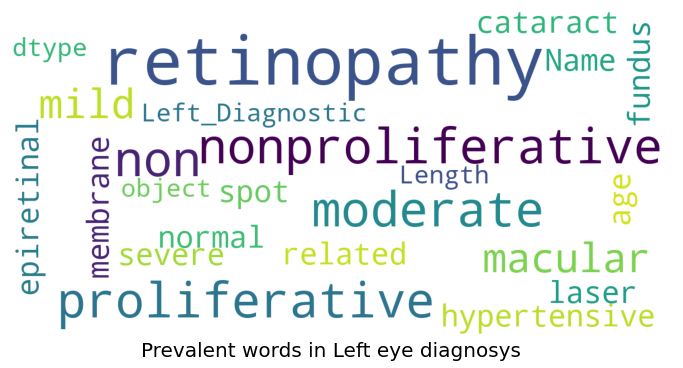

In [ ]:
show_wordcloud(df['Left_Diagnostic'], title = 'Prevalent words in Left eye diagnosys')

We can observe that the words used in diagnosys are quite balanced from the point of view of the two eyes.

Let's look now to people with cataract and check what are the associated texts for left and right diagnosys,

In [ ]:
# Crude estimation of findings ratio
findings = df.iloc[:, -12:-4]
totals = findings.sum()
totals

Normal          2101
Diabetes        2123
Glaucoma         397
Cataract         402
Amd              319
Hypertension     203
Myopia           306
Other           1588
dtype: int64

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = ['Diabetes','Normal', 'Glaucoma', 'Cataract', 'Age related Macular Degeneration', 'Hypertension', 'Pathological Myopia', 'Other abnormalities']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values = [2101, 2123, 397, 402,319,203,306,1588]),
              1, 1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    #title_text="Global",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Eyes diagnosis', x=0.15, y=0.5, font_size=16, showarrow=False)])
fig.show()

In [ ]:
# Helper functions
def filter_df(df, letter):
    filtered = df.loc[(df[letter] == 1)]
    return filtered


def display_grid(df, keyword):
    rows = 2
    cols = 4
    nr_images = rows*cols
    axes=[]
    fig=plt.figure(figsize=(16,8))
    filtered = df.loc[df['Left_Diagnostic'].str.contains(keyword)]
    
    if filtered.shape[0] < nr_images:
        nr_images = filtered.shape[0]

    for i in range(nr_images):
        file_name = filtered.iloc[i]['ID']
        file_name = str(file_name) + '_left.jpg'
        image = cv2.imread(os.path.join(IMG_DIR, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # crop horizontal image for esthetics
        if image.shape[1] > image.shape[0]:
            w = image.shape[0]
            x = (image.shape[1] - w)//2
            image = image[:, x:x+w]

        axes.append( fig.add_subplot(rows, cols, i+1) )
        subplot_title = filtered.iloc[i]['Left_Diagnostic']
        # replacing symbol that looks like comma but doesn't show correctly with a regular comma
        subplot_title = subplot_title.replace('，', ', ')  
        axes[-1].set_title('\n'.join(wrap(subplot_title,40)))  
        plt.axis('off')
        plt.imshow(image)
        
    fig.tight_layout()    
    plt.show()

In [ ]:
#Normal
df_N = filter_df(df, 'Normal')
normal = df_N.shape[0]/df.shape[0]*100
normal_f = "{:.2f}".format(normal)
print(f'fraction of healthy patients: {normal_f}%')

fraction of healthy patients: 32.87%


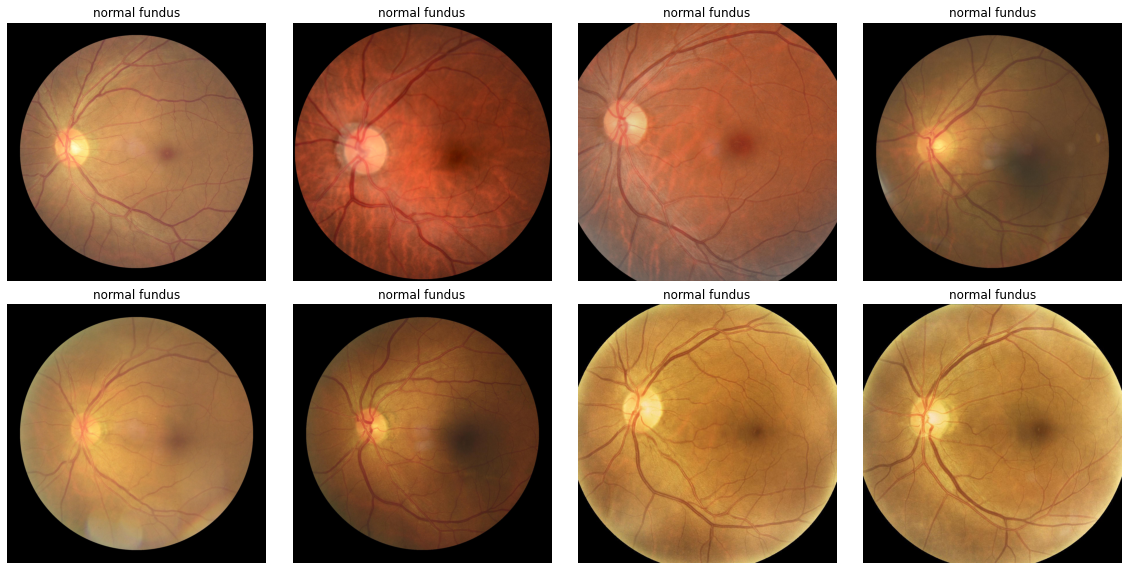

In [ ]:
import cv2
from textwrap import wrap
display_grid(df_N, 'normal fundus')

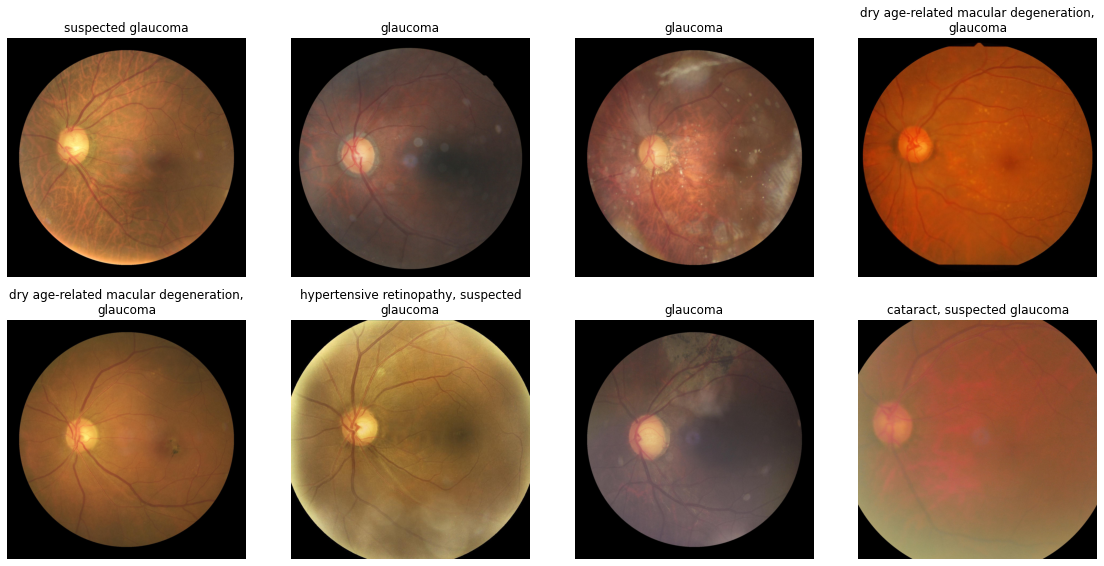

In [ ]:
#Glaucoma
df_G = filter_df(df, 'Glaucoma')
display_grid(df_G, 'glaucoma')

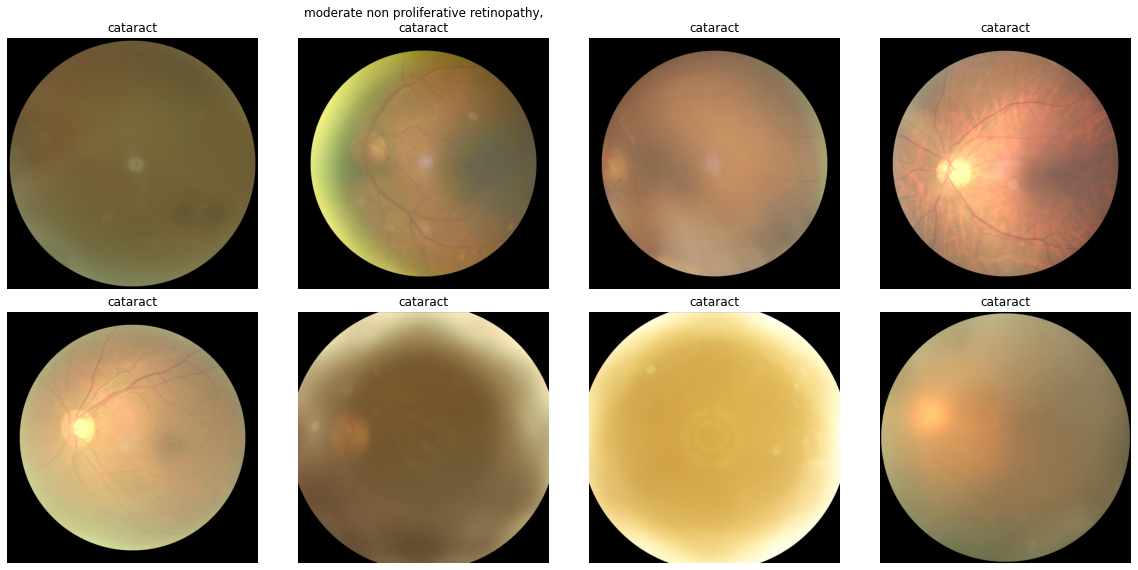

In [ ]:
#Cataract
df_C = filter_df(df, 'Cataract')
display_grid(df_C, 'cataract')

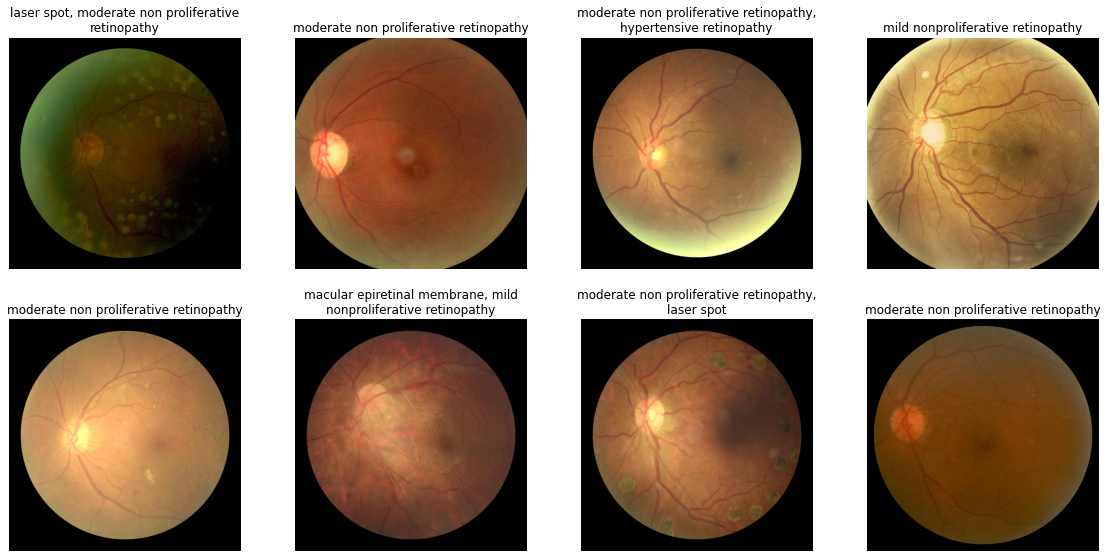

In [ ]:
#Diabetes
df_D = filter_df(df, 'Diabetes')
display_grid(df_D, 'proliferative retinopathy')

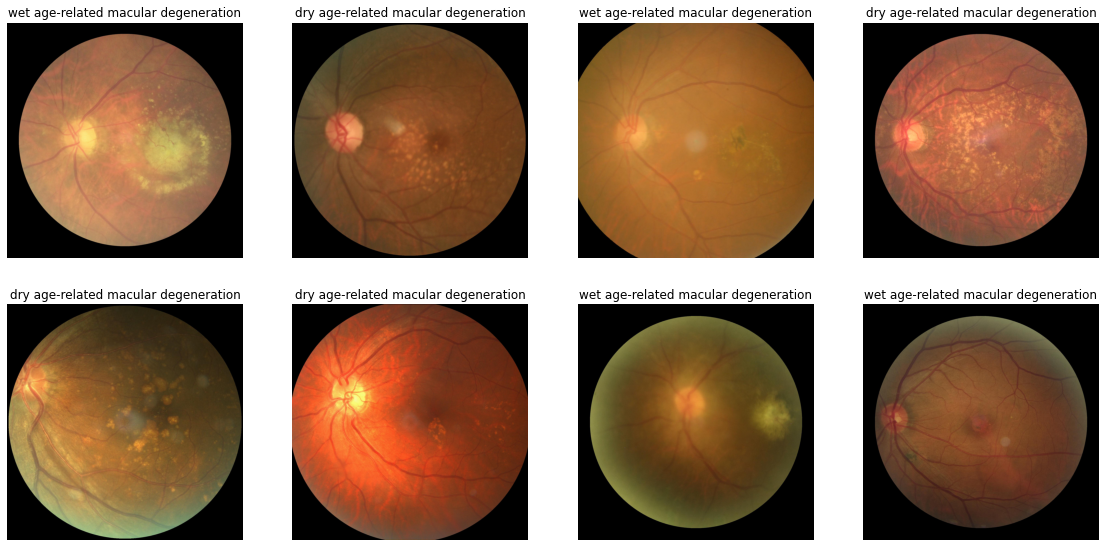

In [ ]:
#Age-related Macular Degeneration (AMD)
df_A = filter_df(df, 'Amd')
display_grid(df_A, 'age-related')

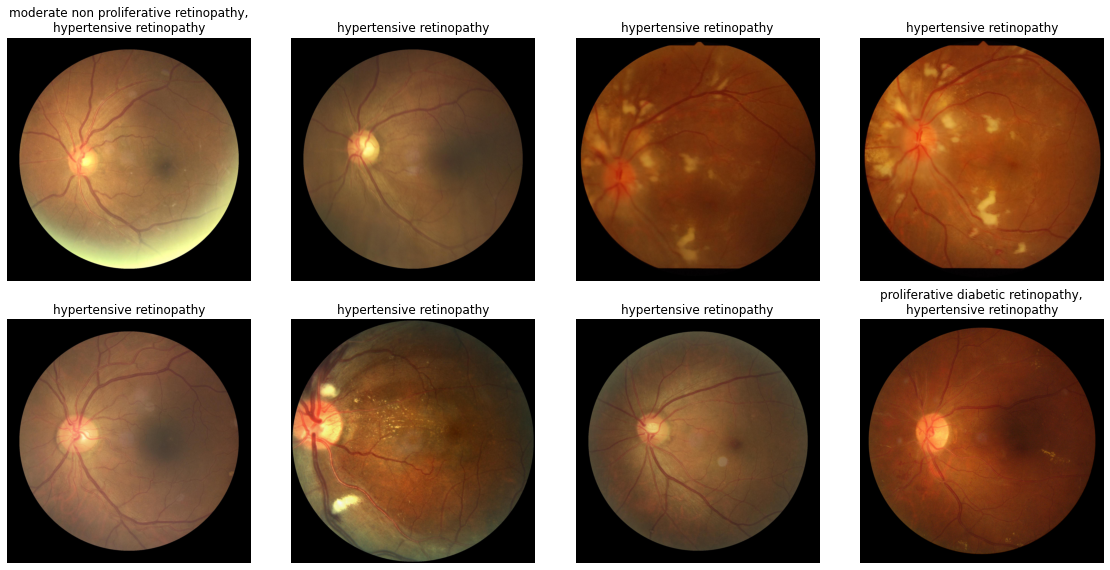

In [ ]:
#Hypertension
df_H = filter_df(df, 'Hypertension')
display_grid(df_H, 'hypertensive')

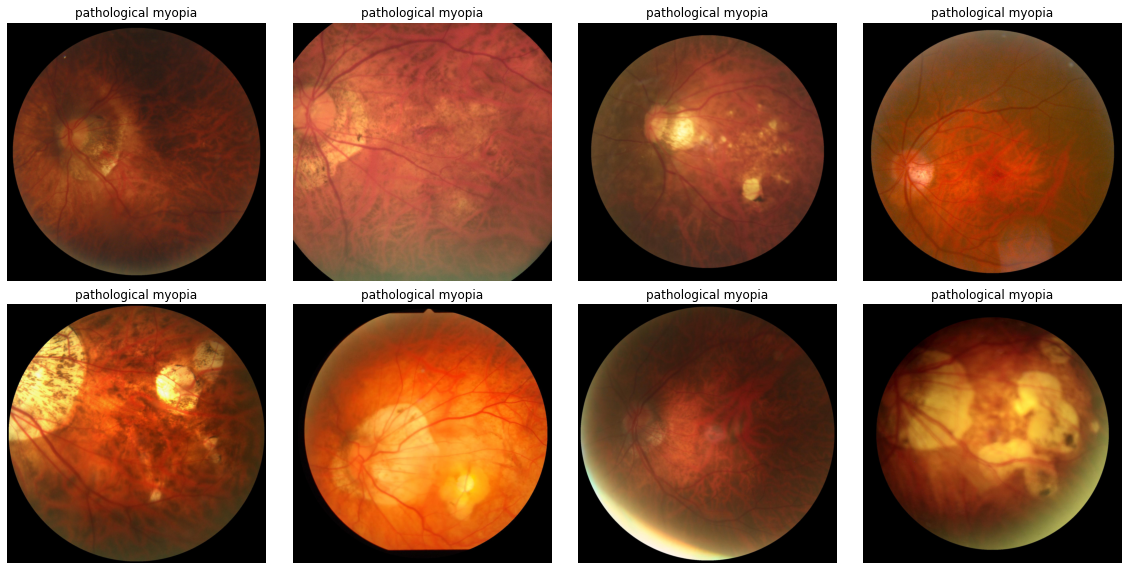

In [ ]:
#Pathological Myopia
df_M = filter_df(df, 'Myopia')
display_grid(df_M, 'myopia')

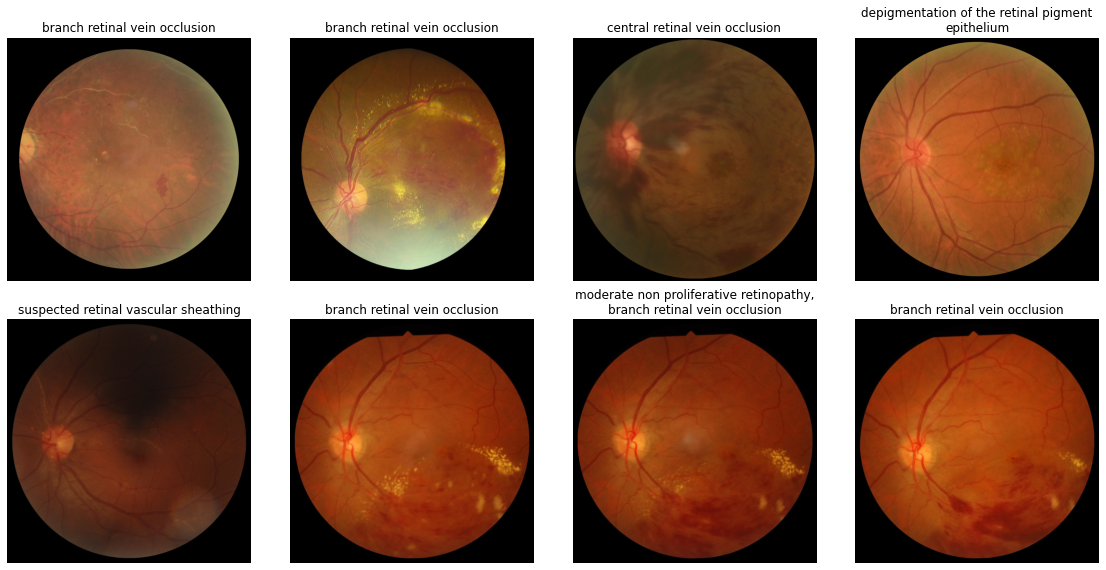

In [ ]:
#Other abnormalities
df_O = filter_df(df, 'Other')
display_grid(df_O, ' retinal')

**Randomize our final combined dataset**

In [ ]:
print(df.loc[(df.Glaucoma==1)].shape)
print(df.loc[df.Glaucoma==0].shape)

(397, 19)
(5995, 19)


In [ ]:
def has_glaucoma_mentioned(text):
    if 'glaucoma' in text:
        return 1
    else:
        return 0

In [ ]:
df['le_glaucoma'] = df['Left_Diagnostic'].apply(lambda x: has_glaucoma_mentioned(x))
df['re_glaucoma'] = df['Right_Diagnostic'].apply(lambda x: has_glaucoma_mentioned(x))

In [ ]:
glaucoma_le_list = df.loc[(df.Glaucoma==1) & (df.le_glaucoma==1)]['Left_Fundus'].values
glaucoma_re_list = df.loc[(df.Glaucoma==1) & (df.re_glaucoma==1)]['Right_Fundus'].values
print(len(glaucoma_le_list), len(glaucoma_re_list))
non_glaucoma_le_list = df.loc[(df.Glaucoma==0) & (df.Left_Diagnostic=="normal fundus")]['Left_Fundus'].sample(332, random_state=314).values
non_glaucoma_re_list = df.loc[(df.Glaucoma==0) & (df.Right_Diagnostic=="normal fundus")]['Right_Fundus'].sample(284, random_state=314).values
print(len(non_glaucoma_le_list), len(non_glaucoma_re_list))

332 284
332 284


In [ ]:
glaucoma_list = np.concatenate((glaucoma_le_list, glaucoma_re_list), axis = 0)
non_glaucoma_list = np.concatenate((non_glaucoma_le_list, non_glaucoma_re_list), axis = 0)
print(len(non_glaucoma_list), len(glaucoma_list))

616 616


In [ ]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_glaucoma):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_glaucoma)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA)
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [ ]:
from random import shuffle
import cv2  as cv
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2

In [ ]:
gal_df = process_data(glaucoma_list, DATA_FOLDER, 1)

100%|██████████| 616/616 [01:05<00:00,  9.38it/s]


In [ ]:
gal_no_df = process_data(non_glaucoma_list, DATA_FOLDER, 0)

100%|██████████| 616/616 [00:44<00:00, 13.99it/s]


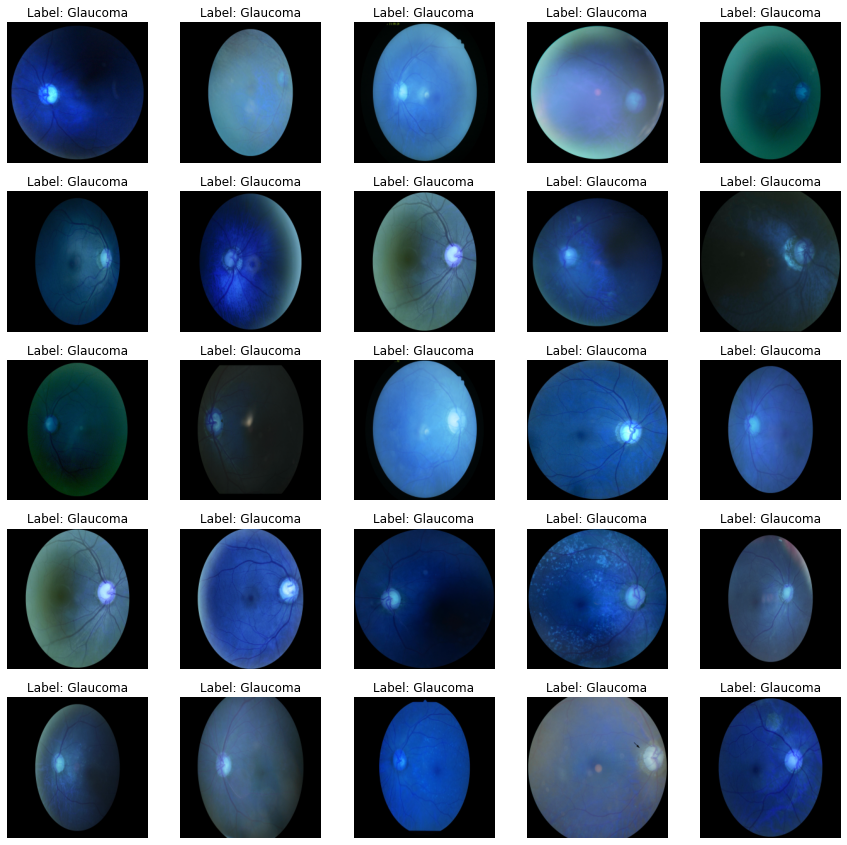

In [ ]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Glaucoma'
        elif label == 1: 
            str_label='No Glaucoma'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(gal_df)

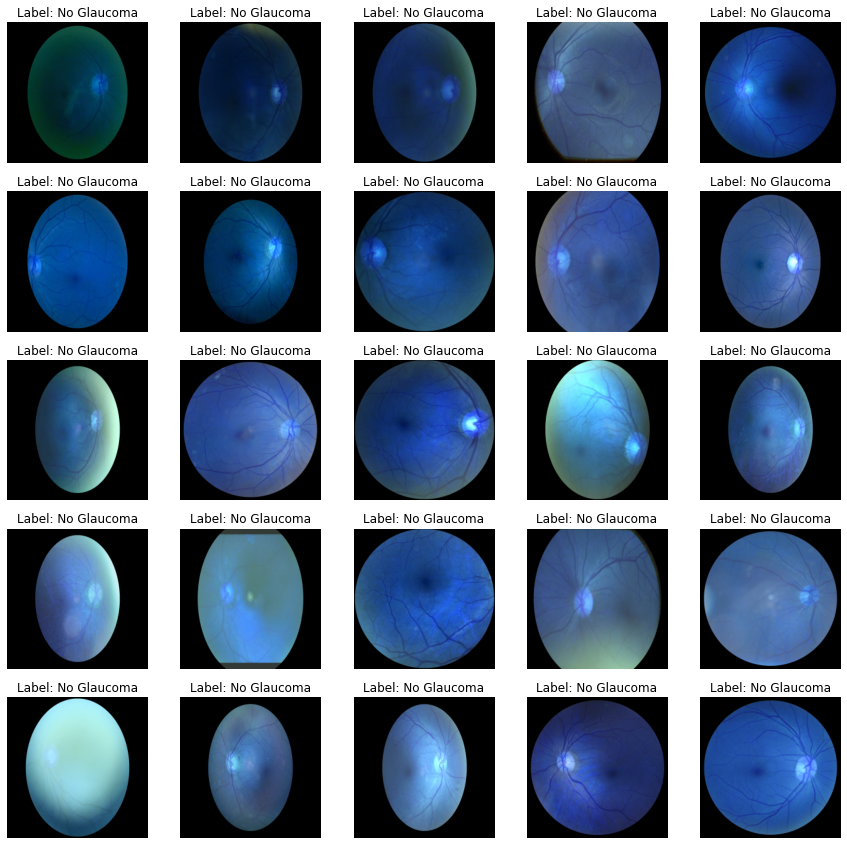

In [ ]:
show_images(gal_no_df)

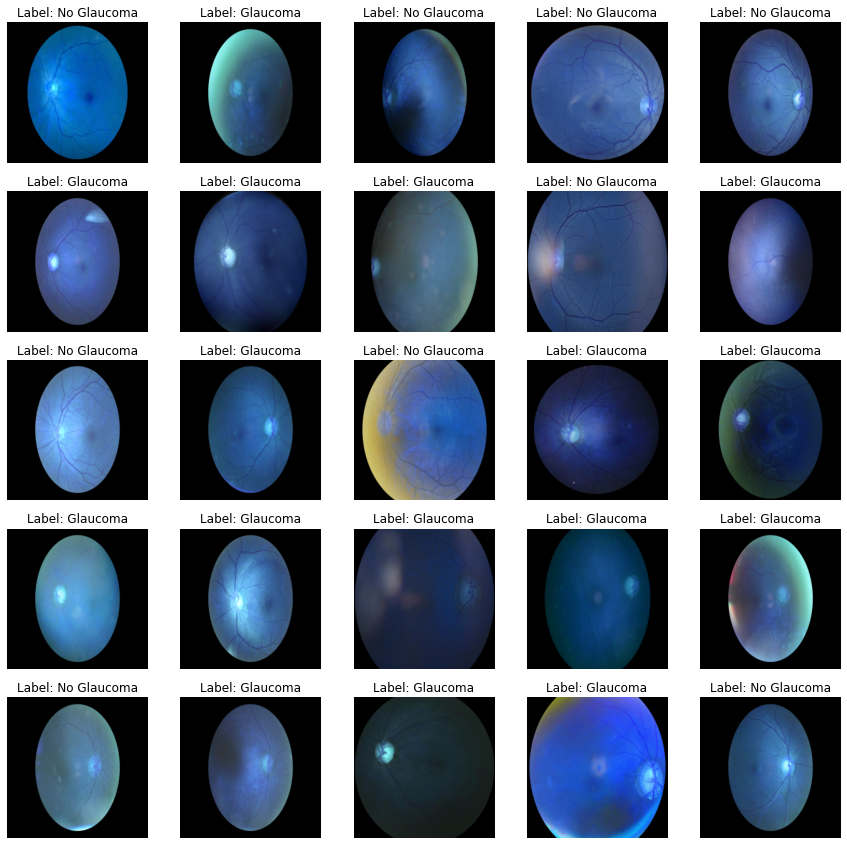

In [ ]:
train = gal_df + gal_no_df
shuffle(train)
show_images(train)

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

#Base line 

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
cnn_model = Sequential()

cnn_model.add(InputLayer(input_shape=X_train.shape[1:]))
cnn_model.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
cnn_model.add(MaxPooling2D())
cnn_model.add(GlobalAveragePooling2D())
cnn_model.add(Dense(20, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid')) 

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
cnn_model.fit(X_train, y_train,
                  batch_size=32,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
31/31 [==============================] - 1s 25ms/step - loss: 1.1035 - accuracy: 0.4751 - val_loss: 0.7947 - val_accuracy: 0.5506
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.7666 - accuracy: 0.4944 - val_loss: 0.7202 - val_accuracy: 0.4656
Epoch 3/50
31/31 [==============================] - 1s 17ms/step - loss: 0.7202 - accuracy: 0.4944 - val_loss: 0.6876 - val_accuracy: 0.4980
Epoch 4/50
31/31 [==============================] - 1s 17ms/step - loss: 0.7003 - accuracy: 0.5178 - val_loss: 0.6785 - val_accuracy: 0.5182
Epoch 5/50
31/31 [==============================] - 0s 16ms/step - loss: 0.7127 - accuracy: 0.5208 - val_loss: 0.7060 - val_accuracy: 0.5101
Epoch 6/50
31/31 [==============================] - 0s 16ms/step - loss: 0.7180 - accuracy: 0.5239 - val_loss: 0.7854 - val_accuracy: 0.5020
Epoch 7/50
31/31 [==============================] - 1s 17ms/step - loss: 0.6822 - accuracy: 0.5553 - val_loss: 0.6826 - val_accuracy: 0.5951
Epoch 8/50
31

In [ ]:
score = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6691083908081055
Validation accuracy: 0.6194332242012024


#Train model ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

In [ ]:
#opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_14 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                   validation_data=(X_val, y_val))

Epoch 1/50
31/31 [==============================] - 15s 339ms/step - loss: 17.5250 - accuracy: 0.5543 - val_loss: 1921.9292 - val_accuracy: 0.5020
Epoch 2/50
31/31 [==============================] - 10s 308ms/step - loss: 1.2869 - accuracy: 0.6376 - val_loss: 2496.7429 - val_accuracy: 0.4939
Epoch 3/50
31/31 [==============================] - 10s 309ms/step - loss: 0.8971 - accuracy: 0.6711 - val_loss: 3.9334 - val_accuracy: 0.5101
Epoch 4/50
31/31 [==============================] - 10s 331ms/step - loss: 0.9360 - accuracy: 0.6782 - val_loss: 5.9254 - val_accuracy: 0.5789
Epoch 5/50
31/31 [==============================] - 10s 331ms/step - loss: 0.7777 - accuracy: 0.7249 - val_loss: 2.1457 - val_accuracy: 0.6113
Epoch 6/50
31/31 [==============================] - 10s 312ms/step - loss: 0.7117 - accuracy: 0.7695 - val_loss: 0.9308 - val_accuracy: 0.6194
Epoch 7/50
31/31 [==============================] - 10s 313ms/step - loss: 0.6098 - accuracy: 0.7756 - val_loss: 0.7053 - val_accuracy:

#Validation results

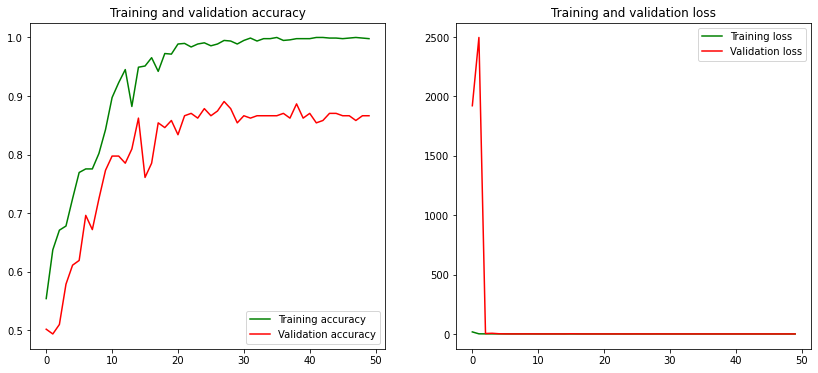

In [ ]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [ ]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.42272016406059265
Validation accuracy: 0.8663967847824097


In [ ]:
#get the predictions for the test data
#y_pred = np.argmax(model.predict(X_val,axis=-1))
y_pred = (model.predict(X_val) > 0.5).astype("int32")
#get the indices to be plotted
#y_true = np.argmax(y_val,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('Classification Report')
target_names = ['Glaucoma', 'Normal']
print(classification_report(y_val, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Glaucoma       0.84      0.90      0.87       123
      Normal       0.90      0.83      0.86       124

   micro avg       0.87      0.87      0.87       247
   macro avg       0.87      0.87      0.87       247
weighted avg       0.87      0.87      0.87       247
 samples avg       0.87      0.87      0.87       247



**Split our dataframe into test, train, validation dataframes**


In [ ]:
df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

988
790
198


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
#Convert row objects to string type
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

**Create test, train and validation image data generators**

In [ ]:
#image size
img_size = 224

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code  -- need to 

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 632 validated image filenames belonging to 2 classes.
Found 158 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [ ]:
## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Create check point and early stop**
<br>
A check point allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

The early stop will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

**Constants for our training run**
<br>
SPE is 'steps per epoch'
<br>
n_val_steps is 'number of validation steps'

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 50
print(n_spe,n_val_steps)

19 4


In [ ]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 2.0811 - accuracy: 0.5600
Epoch 00001: val_accuracy improved from -inf to 0.57812, saving model to vgg16_1.h5
19/19 [==============================] - 17s 715ms/step - loss: 2.0811 - accuracy: 0.5600 - val_loss: 0.7066 - val_accuracy: 0.5781
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.5450
Epoch 00002: val_accuracy did not improve from 0.57812
19/19 [==============================] - 15s 693ms/step - loss: 0.9289 - accuracy: 0.5450 - val_loss: 0.7003 - val_accuracy: 0.5156
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.8007 - accuracy: 0.5050
Epoch 00003: val_accuracy did not improve from 0.57812
19/19 [==============================] - 15s 714ms/step - loss: 0.8007 - accuracy: 0.5050 - val_loss: 0.6980 - val_accuracy: 0.4844
Epoch 4/50
19/19 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.5700
Epoch 00004: val_accuracy improved

In [ ]:
#Load our saved model
#from keras.models import load_model
#model.save("./vgg16_1.h5", save_format="h5")
#model = load_model('./vgg16_1.h5')

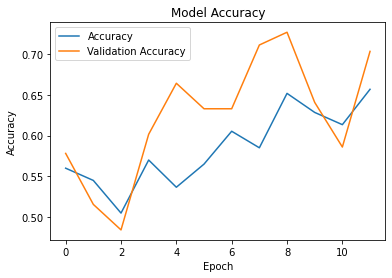

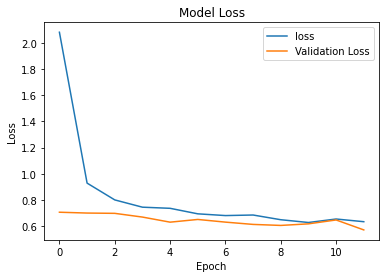

In [ ]:
#Plot accuracy versus loss
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [ ]:
test_generator.reset()

In [ ]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

6/6 [==============================] - 2s 244ms/step


In [ ]:
#Prediction raw data
## let's get the first 10 rows
print(pred[0:10])

[[0.91035086 0.08964914]
 [0.19941892 0.8005811 ]
 [0.56657284 0.43342718]
 [0.04864969 0.9513504 ]
 [0.7834059  0.21659407]
 [0.26342946 0.7365706 ]
 [0.15145144 0.84854853]
 [0.07887399 0.921126  ]
 [0.7738373  0.22616266]
 [0.21414705 0.78585297]]


#Convert raw prediction data
Let's convert the raw data into something more friendly, 1's and 0's. Argmax will do this for us!

In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)
## print the same 10 rows
print(predicted_class_idx[0:10])

[0 1 0 1 0 1 1 1 0 1]


In [ ]:
print(len(predicted_class_idx))

198


#Evaluate our model's accuracy


In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

7/7 [==============================] - 3s 250ms/step - loss: 0.5382 - accuracy: 0.7222


[0.5381860733032227, 0.7222222089767456]

#Convert one-hot category labels to text labels


In [ ]:
valid_generator.class_indices.items()

dict_items([('glaucoma', 0), ('normal', 1)])

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [ ]:
pred_labels[1:10]

['normal',
 'glaucoma',
 'normal',
 'glaucoma',
 'normal',
 'normal',
 'normal',
 'glaucoma',
 'normal']

#Build a new dataframe


In [ ]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

Filename Prediction
0   1306_left.jpg   glaucoma
1   2630_left.jpg     normal
2   1309_left.jpg   glaucoma
3  2418_right.jpg     normal
4  1222_right.jpg   glaucoma

#Verify prediction dataframe results

In [ ]:
prediction_df.iloc[35]

Filename      3289_left.jpg
Prediction           normal
Name: 35, dtype: object

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

3289_left.jpg
1


#Correct vs. Incorrect list

In [ ]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary
new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'glaucoma': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   glaucoma    glaucoma      1306_left.jpg
 Correct   normal    normal      2630_left.jpg
 Correct   glaucoma    glaucoma      1309_left.jpg
 Correct   normal    normal      2418_right.jpg
 Correct   glaucoma    glaucoma      1222_right.jpg
 Correct   normal    normal      1092_left.jpg
 Correct   normal    normal      2835_left.jpg
 Correct   normal    normal      1039_right.jpg
 Correct   glaucoma    glaucoma      1309_right.jpg
 Correct   normal    normal      2596_left.jpg
 Correct   normal    normal      2587_left.jpg
 Correct   normal    normal      2626_right.jpg
 Wrong     glaucoma    normal      2902_left.jpg
 Wrong     normal    glaucoma      1234_right.jpg
 Correct   glaucoma    glaucoma      2048_right.jpg
 Correct   glaucoma    glaucoma      1318_left.jpg
 Correct   normal    normal      3140_right.jpg
 Correct   normal    normal      426_left.jpg
 Correct   glaucoma    glaucoma      149

#Another approach to generator data

In [ ]:
x_test, y_test = test_generator.next()


In [ ]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.  

print(len(pred))

32
32
198


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 0s 411ms/step - loss: 0.4744 - accuracy: 0.8750
loss: 0.4744464159011841
Accuracy: 0.875


#Prediction vs Test image grid

In [ ]:
test_image_data, test_labels = test_generator.next()

In [ ]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [ ]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

1306_left.jpg
0


'glaucoma'

#Convert test labels

In [ ]:
test_labels[5]

array([1., 0.], dtype=float32)

In [ ]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1])

#Plot our comparison grid

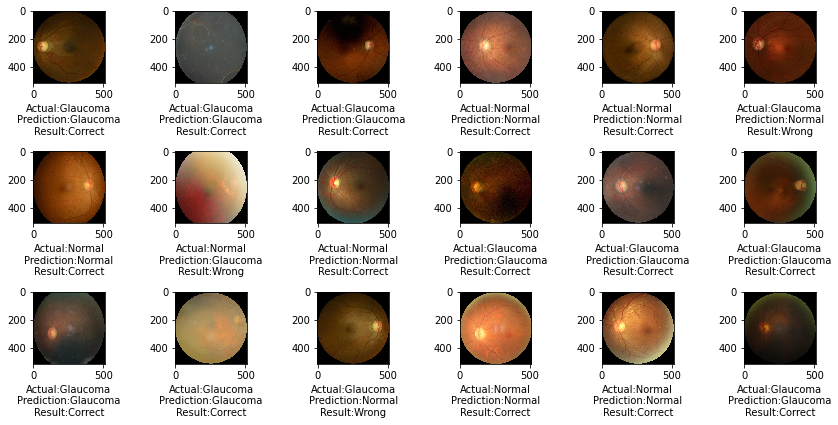

In [ ]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 1:
        label = "Normal"
    else:
        label = "Glaucoma"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}".format(label,pred_label,result))
plt.tight_layout() 

#Classification report

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print('Classification Report')
target_names = ['Glaucoma', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Glaucoma       0.69      0.80      0.74        99
      Normal       0.76      0.65      0.70        99

    accuracy                           0.72       198
   macro avg       0.73      0.72      0.72       198
weighted avg       0.73      0.72      0.72       198



#Confusion matrix

In [ ]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[79, 20],
       [35, 64]])

#Plot confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['glaucoma','normal']

Confusion matrix, without normalization
[[79 20]
 [35 64]]


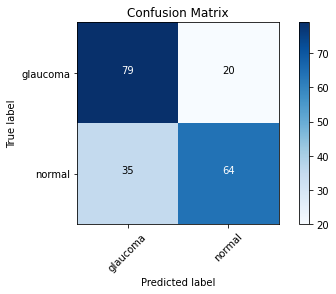

In [ ]:
import itertools
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')